In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jasonhendrawan","key":"847a95fc9ad2eceff9a54b356c07866f"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          32468        880  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                               6KB  2023-05-28 18:26:48           3936        112  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                   22KB  2023-05-12 13:06:39           6067        128  1.0              
mohithsairamreddy/salary-data 

In [ ]:
! kaggle datasets download -d mrmorj/hate-speech-and-offensive-language-dataset
! kaggle datasets download -d arkhoshghalb/twitter-sentiment-analysis-hatred-speech

  0% 0.00/1.01M [00:00<?, ?B/s]
100% 1.01M/1.01M [00:00<00:00, 157MB/s]
  0% 0.00/1.89M [00:00<?, ?B/s]
100% 1.89M/1.89M [00:00<00:00, 196MB/s]


In [ ]:
import pandas as pd
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Input, Embedding,SpatialDropout1D
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from keras.models import Sequential
nltk.download("stopwords")
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))
!unzip "/content/hate-speech-and-offensive-language-dataset.zip" -d "hate_speech"
!unzip "/content/twitter-sentiment-analysis-hatred-speech.zip" -d "twitter"

Archive:  /content/hate-speech-and-offensive-language-dataset.zip
  inflating: hate_speech/labeled_data.csv  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Archive:  /content/twitter-sentiment-analysis-hatred-speech.zip
  inflating: twitter/test.csv        
  inflating: twitter/train.csv       


In [ ]:
twt=pd.read_csv("/content/twitter/train.csv")
off=pd.read_csv("/content/hate_speech/labeled_data.csv")

In [ ]:
print(twt)
print("")
print(off)

          id  label                                              tweet
0          1      0   @user when a father is dysfunctional and is s...
1          2      0  @user @user thanks for #lyft credit i can't us...
2          3      0                                bihday your majesty
3          4      0  #model   i love u take with u all the time in ...
4          5      0             factsguide: society now    #motivation
...      ...    ...                                                ...
31957  31958      0  ate @user isz that youuu?ðððððð...
31958  31959      0    to see nina turner on the airwaves trying to...
31959  31960      0  listening to sad songs on a monday morning otw...
31960  31961      1  @user #sikh #temple vandalised in in #calgary,...
31961  31962      0                   thank you @user for you follow  

[31962 rows x 3 columns]

       Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0               0      3            0       

In [ ]:
twt.drop('id',axis=1,inplace=True)

off.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'],axis=1,inplace=True)
off[off['class']==0]['class']=1
off["class"].replace({0: 1}, inplace=True)
off["class"].replace({2: 0}, inplace=True)
off.rename(columns ={'class':'label'}, inplace = True)
off.iloc[0]['tweet']
off.iloc[5]['tweet']\

frame=[twt,off]
df = pd.concat(frame)

<ipython-input-32-766b118d84d9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  off[off['class']==0]['class']=1


In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

In [ ]:
df['tweet']=df['tweet'].apply(clean_text)

In [ ]:
def make_wordcloud(df):
    comment_words=""
    for val in df.tweet:
        val = str(val).lower()


        comment_words += " ".join(val)+" "
    print(comment_words[0:100])
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,min_font_size = 10).generate(comment_words)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

In [ ]:
x=df['tweet']
y=df['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [ ]:
max_words = 50000
max_len = 300
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [ ]:
model = Sequential()
model.add(Embedding(max_words, 100, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 300, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,080,501
Trainable params: 5,080,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(sequences_matrix,y_train,batch_size=1024,epochs=5,
          validation_split=0.1)

Epoch 1/5
38/38 [==============================] - 11s 227ms/step - loss: 0.5472 - accuracy: 0.7130 - val_loss: 0.3171 - val_accuracy: 0.9013
Epoch 2/5
38/38 [==============================] - 7s 185ms/step - loss: 0.2215 - accuracy: 0.9251 - val_loss: 0.1983 - val_accuracy: 0.9307
Epoch 3/5
38/38 [==============================] - 7s 200ms/step - loss: 0.1166 - accuracy: 0.9617 - val_loss: 0.1772 - val_accuracy: 0.9391
Epoch 4/5
38/38 [==============================] - 6s 159ms/step - loss: 0.0732 - accuracy: 0.9773 - val_loss: 0.1842 - val_accuracy: 0.9396
Epoch 5/5
38/38 [==============================] - 6s 158ms/step - loss: 0.0509 - accuracy: 0.9840 - val_loss: 0.2129 - val_accuracy: 0.9326


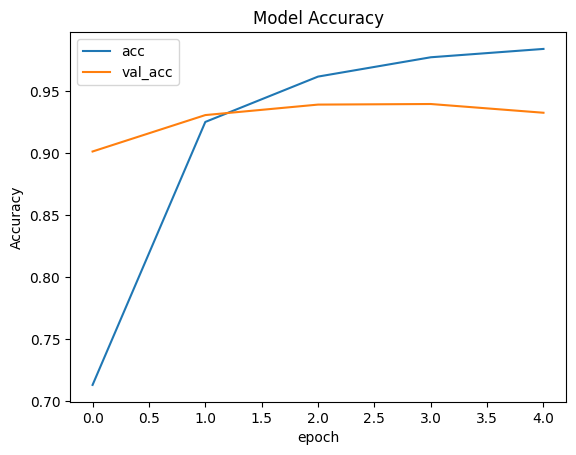

In [ ]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'],loc='upper left')
plt.show()

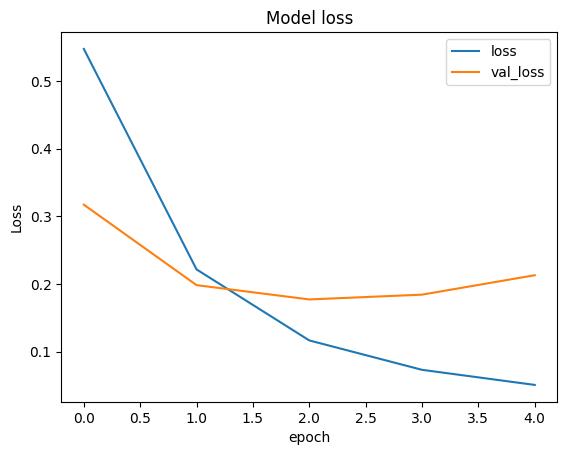

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

In [ ]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix,y_test)


444/444 [==============================] - 3s 7ms/step - loss: 0.2144 - accuracy: 0.9301


In [ ]:
lstm_prediction=model.predict(test_sequences_matrix)


444/444 [==============================] - 3s 6ms/step


In [ ]:
res=[]
for prediction in lstm_prediction:
    if prediction[0]<0.5:
        res.append(0)
    else:
        res.append(1)
print(confusion_matrix(y_test,res))
print(classification_report(y_test, res))

[[7912  541]
 [ 451 5283]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      8453
           1       0.91      0.92      0.91      5734

    accuracy                           0.93     14187
   macro avg       0.93      0.93      0.93     14187
weighted avg       0.93      0.93      0.93     14187



In [ ]:
test = 'YOU LOOK\S %S  FUCKING UGLY'
test=[clean_text(test)]
print(test)
seq = tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)
pred = model.predict(padded)
print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hateful and abusive")

['look  fuck ugli']
[[26, 12, 256]]
1/1 [==============================] - 0s 26ms/step
pred [[0.9487756]]
hateful and abusive


In [ ]:
test = 'YOU arE\S absolutely %S  pretty 1 3 2'
test=[clean_text(test)]
print(test)
seq = tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)
pred = model.predict(padded)
print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hateful and abusive")

['are absolut  pretti   ']
[[865, 292]]
1/1 [==============================] - 0s 24ms/step
pred [[0.28984302]]
no hate


In [ ]:
test = 'you ReALLy are ShittY ToDaY'
test=[clean_text(test)]
print(test)
seq = tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)
pred = model.predict(padded)
print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hateful and abusive")

['realli shitti today']
[[53, 1527, 32]]
1/1 [==============================] - 0s 23ms/step
pred [[0.78926677]]
hateful and abusive


In [ ]:
test = 'you * are % like a $@% dumb MonKey '
test=[clean_text(test)]
print(test)
seq = tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)
pred = model.predict(padded)
print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hateful and abusive")

['  like  dumb monkey ']
[[5, 232, 409]]
1/1 [==============================] - 0s 31ms/step
pred [[0.86727434]]
hateful and abusive


In [ ]:
test = 'you look really fucking good today'
test=[clean_text(test)]
print(test)
seq = tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)
pred = model.predict(padded)
print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hateful and abusive")

['look realli fuck good today']
[[26, 53, 12, 30, 32]]
1/1 [==============================] - 0s 25ms/step
pred [[0.437186]]
no hate
